# c_beta Analysis

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import MolecularClocks.src.methylation_util as m_util
from MolecularClocks.src.invasiveCpGs_consts import getConsts

consts = getConsts(['gene_module_dict', 'all_module_genes'])

sns.set(rc={"savefig.bbox":'tight'}, font_scale=1.2, style='white')

In [2]:
figure_outdir = 'figures'
if not os.path.exists(figure_outdir):
    os.mkdir(figure_outdir)

## Prep data

In [3]:
TCGA_clinical_dir = os.path.join(consts['official_indir'], 'TCGA')
TCGA_c_beta_dir = os.path.join(consts['repo_dir'], 'Select_fCpGs', 'outputs')
Ringner_clinical_dir = os.path.join(consts['official_indir'], 'Ringner')
Ringner_c_beta_dir = os.path.join(consts['repo_dir'], 'Process_Other_Data_Sources', 'outputs', 'cohort_T2')

In [4]:
clinical = {}

In [5]:
# Import step for ringner data

clinical['ringner'] = pd.read_table(os.path.join(Ringner_clinical_dir, 'cohort.T2.clinical.txt'), index_col=0, dtype={'grade':str})
clinical['ringner']['c_beta'] = pd.read_table(os.path.join(Ringner_c_beta_dir, 'cohort.T2.c_beta.txt'), index_col=0).squeeze("columns")

In [6]:
# Initial import step for TCGA data

clinical['TCGA'] = pd.read_table(os.path.join(TCGA_clinical_dir, 'cohort1.clinical.tsv'), index_col=0)
clinical['TCGA'] = clinical['TCGA'].set_index('bcr_patient_barcode')
c_beta_tcga = pd.read_table(os.path.join(TCGA_c_beta_dir, 'cohort.T1.c_beta.txt'), index_col=0, header=None).squeeze("columns")
c_beta_tcga.index = c_beta_tcga.index.to_series().apply(consts['sampleIDtoPatientID'])
clinical['TCGA']['c_beta'] = c_beta_tcga

clinical['TCGA']['T Stage'] = clinical['TCGA']['ajcc_pathologic_t'].dropna().apply(lambda x:x[:2])
clinical['TCGA']['Stage'] = clinical['TCGA']['ajcc_pathologic_stage'].dropna().str.rstrip('ABC')
clinical['TCGA']['age'] = clinical['TCGA']['age_at_diagnosis'] / 365

### IHC status

In [7]:
# Import and process table with hormone status 

marker_state_dict = {
#                      'Equivocal':float('NaN'),
                     'Equivocal':'Positive',
                     'Indeterminate':float('NaN'),
                     'Negative':'Negative', 'Positive':'Positive'}
ihc_status = pd.read_table(os.path.join(TCGA_clinical_dir, 'nationwidechildrens.org_clinical_patient_brca.txt'),
                           usecols=['bcr_patient_barcode', 'her2_status_by_ihc', 'er_status_by_ihc', 'pr_status_by_ihc'],
                           index_col=0, na_values=['[Not Evaluated]', '[Not Available]']).iloc[2:]
ihc_status = ihc_status.apply(lambda col:col.map(marker_state_dict), axis=0)
assert not ihc_status.index.duplicated().any()
assert ihc_status.index.isin(clinical['TCGA'].index).all()

In [8]:
# print('All BRCA cases')
# display(ihc_status.apply(lambda x:x.value_counts()).fillna(0))

# analysis_submitterIDs = clinical['TCGA'].index[clinical['TCGA']['in_analysis_dataset']]
# print('Pure ductal cases')
# display(ihc_status.loc[analysis_submitterIDs].apply(lambda x:x.value_counts()).fillna(0))

# # display(ihc_status.loc[ihc_status['her2_status_by_ihc']=='Equivocal'].groupby('er_status_by_ihc')['pr_status_by_ihc'].value_counts().unstack())

In [9]:
# Process ihc status table
# Merge with TCGA clinical table
# Create a "subtype" column

clinical['TCGA'] = clinical['TCGA'].merge(ihc_status, left_index=True, right_index=True, how='left')

clinical['TCGA']['HR+'] = (clinical['TCGA']['er_status_by_ihc'] == 'Positive') | (clinical['TCGA']['pr_status_by_ihc'] == 'Positive')
clinical['TCGA']['HR-'] = (clinical['TCGA']['er_status_by_ihc'] == 'Negative') & (clinical['TCGA']['pr_status_by_ihc'] == 'Negative')

clinical['TCGA']['LumA_type'] = clinical['TCGA']['HR+'] & (clinical['TCGA']['her2_status_by_ihc'] == 'Negative')
clinical['TCGA']['LumB_type'] = clinical['TCGA']['HR+'] & (clinical['TCGA']['her2_status_by_ihc'] == 'Positive')
clinical['TCGA']['Her2_type'] = (clinical['TCGA']['her2_status_by_ihc'] == 'Positive') & clinical['TCGA']['HR-']
clinical['TCGA']['Basal_type'] = clinical['TCGA']['HR-'] & (clinical['TCGA']['her2_status_by_ihc'] == 'Negative')


subtype_list = ['LumA_type', 'LumB_type', 'Her2_type', 'Basal_type']

for subtype in subtype_list:
    clinical['TCGA'][subtype] = clinical['TCGA'][subtype].map({True:subtype.split('_type')[0], False:''})

clinical['TCGA']['subtype'] = clinical['TCGA'][subtype_list].apply(lambda row:''.join(row), axis=1)
clinical['TCGA'].loc[clinical['TCGA']['subtype'] == '', 'subtype'] = None

### RNA-seq

In [10]:
markers_TPM_df = pd.read_table(
    os.path.join(TCGA_clinical_dir, 'cohort1.rnaseq_tpm.tsv'),
    sep='\t')
markers_TPM_df = markers_TPM_df.set_index('gene_id')
gene_name = markers_TPM_df.pop('gene_name')
markers_TPM_df = markers_TPM_df.rename(columns=lambda x:'-'.join(x.split('-')[:3]))

# need_genes = consts['all_module_genes']
# need_genes = np.concatenate([need_genes, ['MCM2', 'MKI67', 'E2F1']])
# markers_TPM_df = markers_TPM_df.loc[gene_name.index[gene_name.isin(need_genes)]]

In [11]:
# mean_log_TPM_per_gene_OLD = pd.read_table('~/Desktop/mean_log_TPM_per_gene_OLD.txt', sep='\t', index_col=0).squeeze('columns')
# mean_log_TPM_per_gene_OLD = mean_log_TPM_per_gene_OLD.loc[need_genes]
# mean_log_TPM_per_gene_OLD = gene_name.to_frame().merge(mean_log_TPM_per_gene_OLD.rename('mean_TPM'), left_on='gene_name', right_index=True)['mean_TPM']

In [12]:
markers_transformed_df = np.log2(markers_TPM_df + 1)

# Mean centered across all tumors for each gene
markers_transformed_df = markers_transformed_df.apply(lambda col:col - markers_transformed_df.mean(axis=1), axis=0)
# markers_transformed_df = markers_transformed_df.apply(lambda col:col - mean_log_TPM_per_gene_OLD.loc[markers_transformed_df.index], axis=0)
assert (markers_transformed_df.mean(axis=1) < 1e-5).all()

# Mean centered across all genes for each tumor
# markers_transformed_df = markers_transformed_df.apply(lambda col:col - markers_transformed_df.mean(axis=0), axis=1)
# markers_transformed_df -= markers_transformed_df.mean(axis=0)
# assert (markers_transformed_df.mean(axis=0) < 1e-5).all()

In [13]:
# Add columns for the average expression of each gene module

for module in consts['gene_module_dict'].keys():
    markers = consts['gene_module_dict'][module]
    selected_TPM = markers_transformed_df.loc[gene_name.index[gene_name.isin(markers)]]
    assert selected_TPM.shape[0] == len(markers)
    avg_module_expression = selected_TPM.mean(axis=0)
    avg_module_expression.name = module
    clinical['TCGA'] = clinical['TCGA'].drop(module, axis=1, errors='ignore')
    clinical['TCGA'] = clinical['TCGA'].merge(avg_module_expression, left_index=True, right_index=True, how='left')
#     clinical['TCGA'][module] = avg_module_expression.loc[clinical['TCGA'].index]

In [14]:
# sns.histplot(clinical['ringner']['Mitotic Checkpoint'])
# sns.histplot(clinical['TCGA']['Mitotic Checkpoint'])

In [15]:
# Making sure sets are independent

# inter_values = np.intersect1d(np.round(clinical['TCGA']['c_beta'], 5), np.round(clinical['ringner']['c_beta'], 5))
# display(clinical['TCGA'].loc[np.round(clinical['TCGA']['c_beta'], 5) == 0.77438])
# display(clinical['ringner'].loc[np.round(clinical['ringner']['c_beta'], 5) == 0.77438])
# 26141.0 / 365

### Copy number analysis

In [16]:
### CNV Analysis

CNV_df = pd.read_table(
    os.path.join(TCGA_clinical_dir, 'cohort1.cnv.tsv'),
    sep='\t')
CNV_df['CN'] = 2 * (2 ** CNV_df['Segment_Mean'])
all_samples = CNV_df['Sample'].unique()

In [17]:
# Sanity check
# Number of probes increases with the length of the segment
# So each segment is a region of the chromosome ith roughly equal copy number

# CNV_df['Length'] = CNV_df['End'] - CNV_df['Start']
# sns.lineplot(data=CNV_df.sample(5000), x='Num_Probes', y='Length')

In [18]:
FGA_loss_threshold = 1.5
FGA_gain_threshold = 2.5

In [19]:
FGA_loss_list = []
FGA_gain_list = []

ploidy_list = []
for samp in all_samples:
# samp = all_samples[0]

    sample_CNV_df = CNV_df.loc[CNV_df['Sample'] == samp]

    total_num_probes = sample_CNV_df['Num_Probes'].sum()
    FGA_loss = sample_CNV_df.loc[sample_CNV_df['CN'] < FGA_loss_threshold, 'Num_Probes'].sum() / total_num_probes
    FGA_gain = sample_CNV_df.loc[sample_CNV_df['CN'] > FGA_gain_threshold, 'Num_Probes'].sum() / total_num_probes

    FGA_loss_list.append(FGA_loss)
    FGA_gain_list.append(FGA_gain)

#     ploidy = (sample_CNV_df['CN'] * sample_CNV_df['Num_Probes']).sum() / total_num_probes
#     ploidy_list.append(ploidy)
FGA_output = pd.DataFrame(index=all_samples, data={'FGA_loss':FGA_loss_list, 'FGA_gain':FGA_gain_list})
FGA_output['FGA'] = FGA_output['FGA_loss'] + FGA_output['FGA_gain']
FGA_output.index = FGA_output.index.to_series().apply(lambda x:'-'.join(x.split('-')[:3]))


# Add new columns to TCGA clinical table
clinical['TCGA'] = clinical['TCGA'].drop(['FGA_loss', 'FGA_gain', 'FGA'], axis=1, errors='ignore')
clinical['TCGA'] = clinical['TCGA'].merge(FGA_output, left_index=True, right_index=True, how='left')

In [20]:
# sns.histplot(x=ploidy_list)
# sns.histplot(CNV_df['CN'].sample(10000)).set(xlim=(0, 10))

### Save annotated clinical file for cohort T1

In [21]:
clinical['TCGA'].to_csv(os.path.join(TCGA_clinical_dir, 'cohort1.clinical.annotated.tsv'), sep='\t')

## Make Figures

In [22]:
clinical['TCGA'].name = 'Cohort T1'
clinical['ringner'].name = 'Cohort T2'

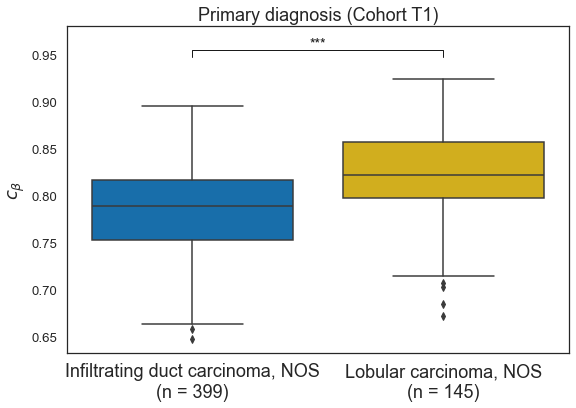

In [23]:
major_diagnoses = ['Infiltrating duct carcinoma, NOS', 'Lobular carcinoma, NOS']
ax = m_util.saveBoxPlotNew(clinical['TCGA'], 'primary_diagnosis', restrict=False,
                   var_y='c_beta',
                   x_size=9, y_size=6,
                   outdir=figure_outdir, title=True, use_groups=major_diagnoses,
                   palette=consts['palette_jco'], signif_fontsize=14)

<Axes: title={'center': 'Grade (Cohort T2)'}, ylabel='$c_β$'>

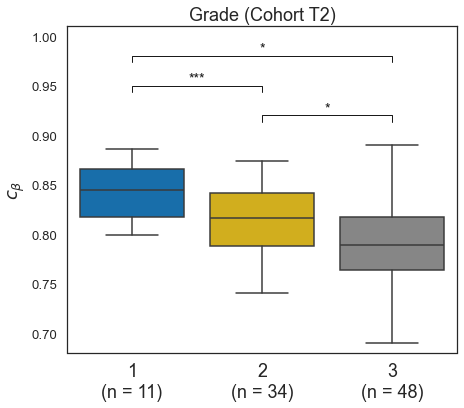

In [24]:
m_util.saveBoxPlotNew(clinical['ringner'], 'grade', restrict=True,
                   var_y='c_beta',
                   x_size=7, y_size=6,
                   outdir=figure_outdir, title=True, use_groups=['1', '2', '3'],
                   palette=consts['palette_jco'])

<Axes: title={'center': 'Stage (Cohort T1)'}, ylabel='$c_β$'>

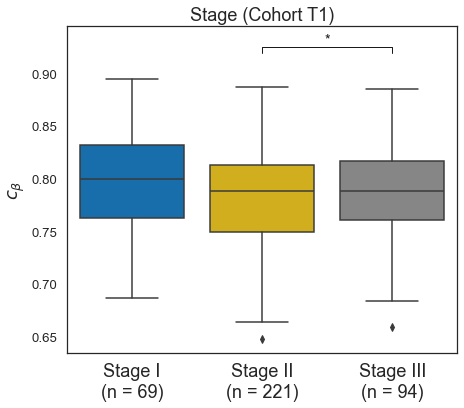

In [25]:
m_util.saveBoxPlotNew(clinical['TCGA'], 'Stage', restrict=True,
                   var_y='c_beta',
                      use_groups = ['Stage I', 'Stage II', 'Stage III'],
                   x_size=7, y_size=6,
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])

<Axes: title={'center': 'Subtype (Cohort T1)'}, ylabel='$c_β$'>

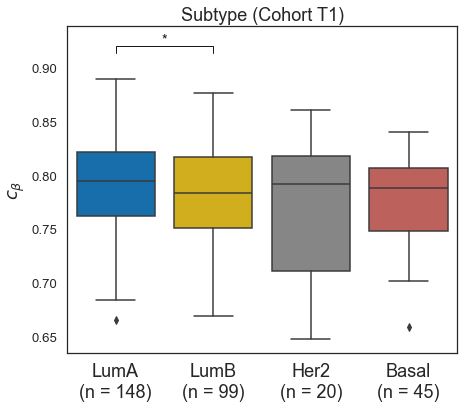

In [26]:
m_util.saveBoxPlotNew(clinical['TCGA'], 'subtype', restrict=True,
                   var_y='c_beta',
                      use_groups = ['LumA', 'LumB', 'Her2', 'Basal'],
                   x_size=7, y_size=6,
                      label = 'Subtype',
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])

In [27]:
clinical_TCGA_old = consts['project_data_func_dict']['TCGA']['sample_annotations']()
pureSamples_TCGA_old = consts['project_data_func_dict']['TCGA']['pureSamples']()
old_analysis_sampleUUIDs = np.intersect1d(pureSamples_TCGA_old, clinical_TCGA_old.index[clinical_TCGA_old['primary_diagnosis'] == 'Infiltrating duct carcinoma, NOS'])

all_caseuuid_caseid = pd.read_table(os.path.join(consts['ALL_dir'], 'all_caseuuid_caseid.tsv'), index_col=0).squeeze('columns')
all_caseuuid_caseid.index = all_caseuuid_caseid.index.str.upper()
assert np.isin(clinical_TCGA_old.loc[old_analysis_sampleUUIDs, 'cases.0.case_id'], all_caseuuid_caseid.index).all()
clinical_TCGA_old = clinical_TCGA_old.merge(all_caseuuid_caseid, left_on='cases.0.case_id', right_index=True)

old_analysis_submitterIDs = clinical_TCGA_old.loc[old_analysis_sampleUUIDs, 'submitter_id']

a = clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'] & (clinical['TCGA']['subtype'] == 'Her2'), 'c_beta']
b = clinical['TCGA'].loc[clinical['TCGA'].index.isin(old_analysis_submitterIDs) & clinical['TCGA']['in_analysis_dataset'] & (clinical['TCGA']['subtype'] == 'Her2'), 'c_beta']

# why is this nan?
# clinical['TCGA'].loc['TCGA-E9-A22G', 'c_beta']

print(a.dropna().shape)
print(b.dropna().shape)
print(a.median())
print(b.median())

(20,)
(15,)
0.791885868928601
0.7527160617030171


<Axes: title={'center': 'Subtype (Cohort T2)'}, ylabel='$c_β$'>

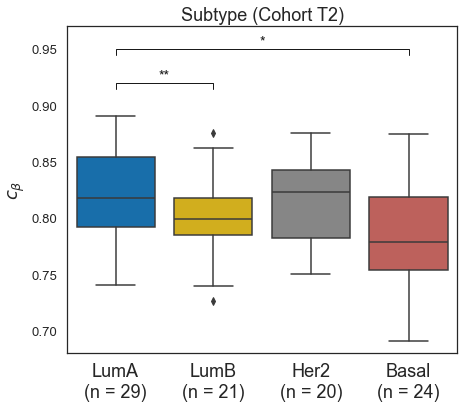

In [28]:
m_util.saveBoxPlotNew(clinical['ringner'], 'genefu.pam50.subtype', restrict=True,
                   var_y='c_beta',
                      use_groups = ['LumA', 'LumB', 'Her2', 'Basal'],
                   x_size=7, y_size=6,
                      label = 'Subtype',
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])

<Axes: title={'center': 'T stage (Cohort T1)'}, ylabel='$c_β$'>

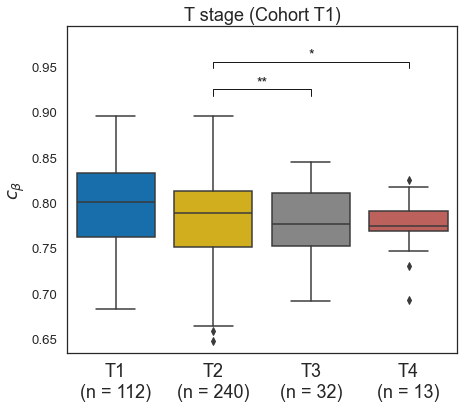

In [29]:
m_util.saveBoxPlotNew(clinical['TCGA'], 'T Stage', restrict=True,
                   var_y='c_beta',
                      use_groups = ['T1', 'T2', 'T3', 'T4'],
                   x_size=7, y_size=6,
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])


<Axes: title={'center': 'Subtype (Luminal Grouped) (Cohort T1)'}, ylabel='$c_β$'>

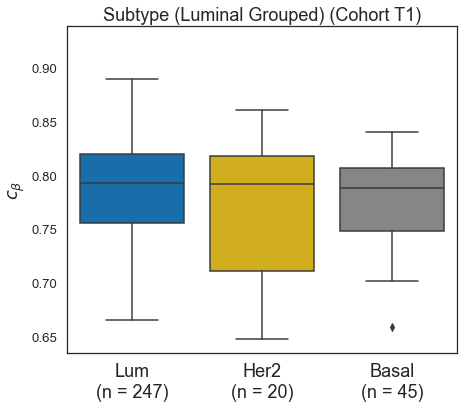

In [30]:
clinical['TCGA']['subtype_lumGrouped'] = clinical['TCGA']['subtype'].copy().map({'LumA':'Lum', 'LumB':'Lum', 'Her2':'Her2', 'Basal':'Basal'})

m_util.saveBoxPlotNew(clinical['TCGA'], 'subtype_lumGrouped', restrict=True,
                   var_y='c_beta',
                      use_groups = ['Lum', 'Her2', 'Basal'],
                   x_size=7, y_size=6,
                      label = 'Subtype (Luminal Grouped)',
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])

<Axes: title={'center': 'Subtype (Luminal Grouped) (Cohort T2)'}, ylabel='$c_β$'>

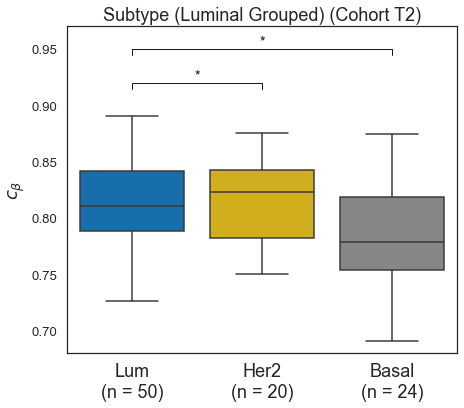

In [31]:
clinical['ringner']['subtype_lumGrouped'] = clinical['ringner']['genefu.pam50.subtype'].copy().map({'LumA':'Lum', 'LumB':'Lum', 'Her2':'Her2', 'Basal':'Basal'})

m_util.saveBoxPlotNew(clinical['ringner'], 'subtype_lumGrouped', restrict=True,
                   var_y='c_beta',
                      use_groups = ['Lum', 'Her2', 'Basal'],
                   x_size=7, y_size=6,
                      label = 'Subtype (Luminal Grouped)',
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])

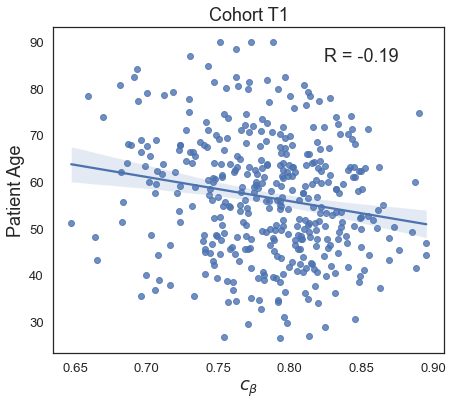

In [32]:
m_util.saveCorrelationPlot(clinical['TCGA'], var_y='age', restrict=True, outfile=True,
                           outdir=figure_outdir,
                           x_size=7, y_size=6,
                           label='Patient Age',
                           text_x=0.85, text_y=85, text_fontsize=18
                          )

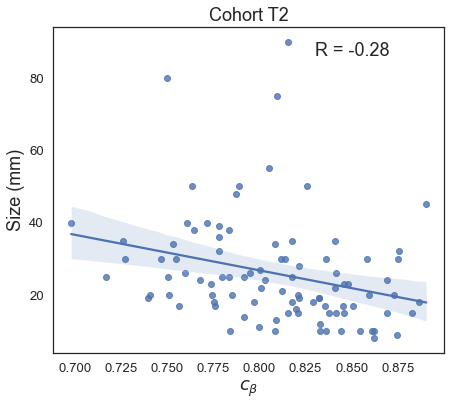

In [33]:
m_util.saveCorrelationPlot(clinical['ringner'], var_y='size', restrict=True, outfile=True,
                           outdir=figure_outdir,
                           x_size=7, y_size=6,
                           label='Size (mm)',
                           text_x=0.85, text_y=85, text_fontsize=18
                          )

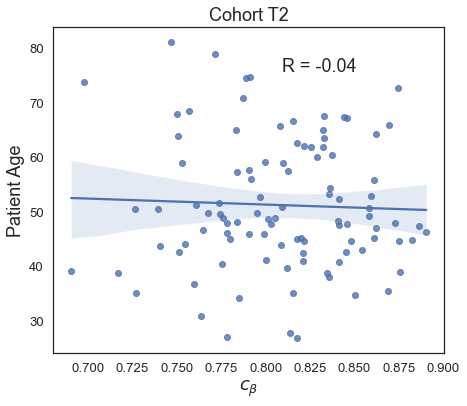

In [34]:
m_util.saveCorrelationPlot(clinical['ringner'], var_y='age', restrict=True, outfile=True,
                           outdir=figure_outdir,
                           x_size=7, y_size=6,
                           label='Patient Age',
                           text_x=0.83, text_y=75, text_fontsize=18
                          )

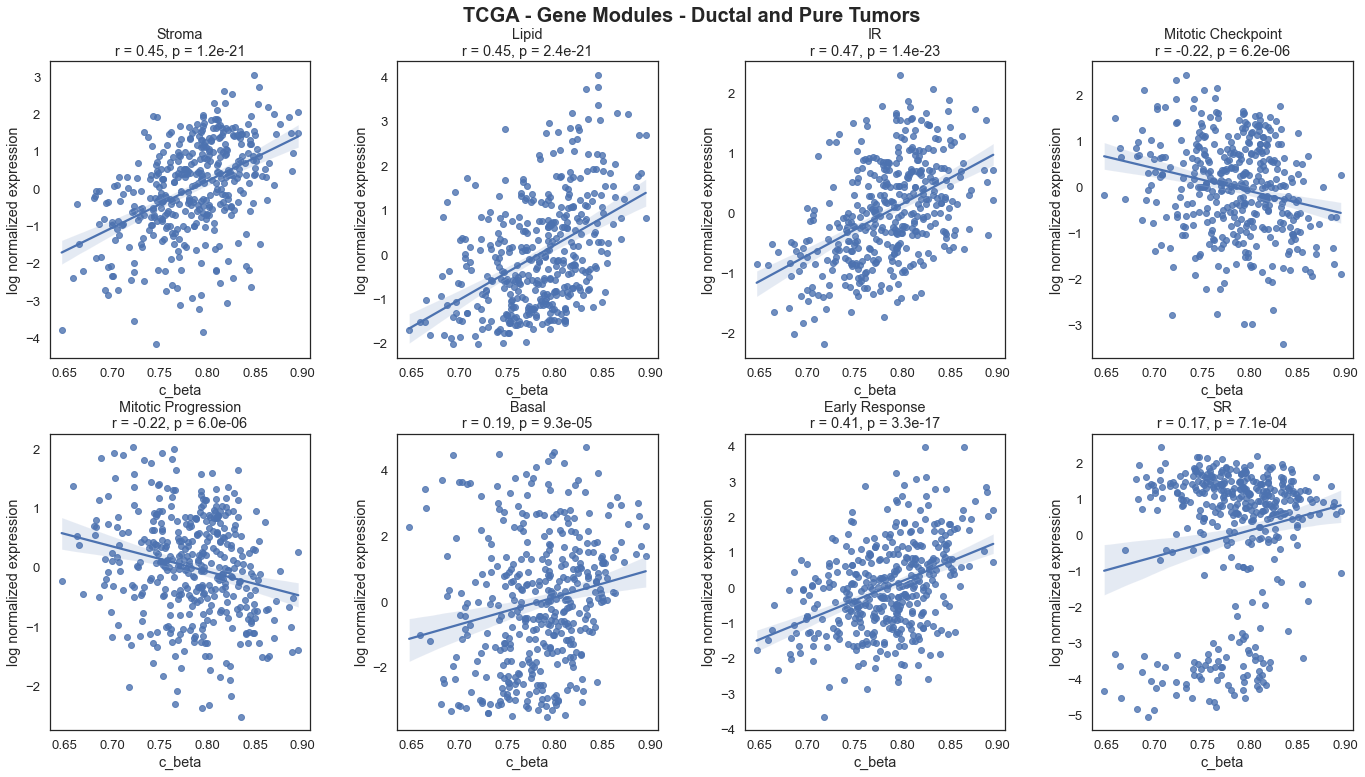

In [35]:
##### NEW
##### 3-25-24
##### Investigating issue of difference in correlation values

ncols = 4
nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 2 + 5*nrows))
fig.suptitle(f'TCGA - Gene Modules - Ductal and Pure Tumors', y=0.92, fontsize=20, fontweight='bold')
fig.tight_layout(pad=5)

plot_df = clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset']]

for i, module in enumerate(consts['gene_module_dict'].keys()):
    row = int(i // ncols)
    col = i % ncols
    
    ax = axes[row, col]
    
    ser1 = plot_df['c_beta']
    ser2 = plot_df[module]
    corr = m_util.pearsonCorrelation(ser1, ser2)
    sns.regplot(ax=ax, x=ser1, y=ser2)
    ax.set_title(f'{module}\nr = {corr.rvalue:.2f}, p = {corr.pvalue:.1e}')
    ax.set_ylabel('log normalized expression')
    ax.set_xlabel('c_beta')

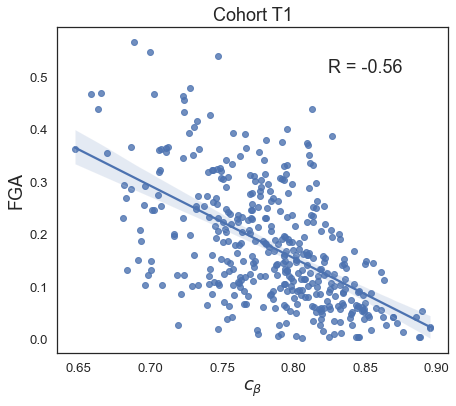

In [36]:
m_util.saveCorrelationPlot(clinical['TCGA'], var_y='FGA', restrict=True, outfile=True,
                           outdir=figure_outdir,
                           x_size=7, y_size=6,
                           label='FGA',
                           text_x=0.85, text_y=0.5, text_fontsize=18
                          )

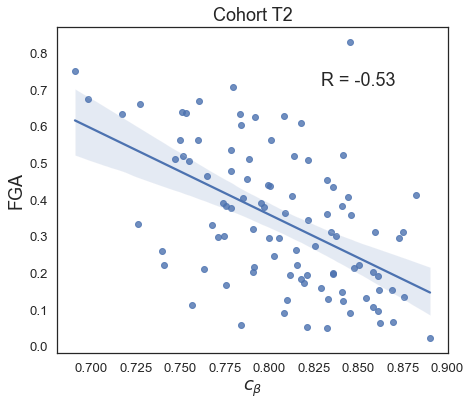

In [37]:
m_util.saveCorrelationPlot(clinical['ringner'], var_y='FGA', restrict=True, outfile=True,
                           outdir=figure_outdir,
                           x_size=7, y_size=6,
                           label='FGA',
                           text_x=0.85, text_y=0.7, text_fontsize=18
                          )

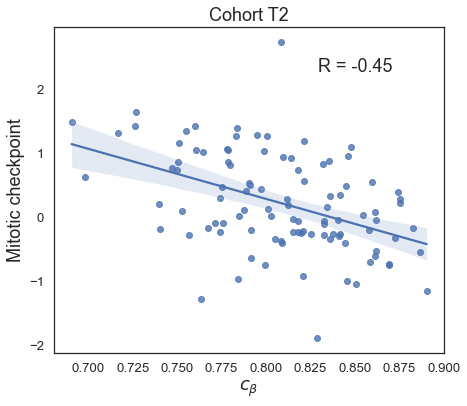

In [38]:
m_util.saveCorrelationPlot(clinical['ringner'], var_y='Mitotic Checkpoint', restrict=True, outfile=True,
                           outdir=figure_outdir,
                           x_size=7, y_size=6,
                           text_x=0.85, text_y=2.2, text_fontsize=18
                          )

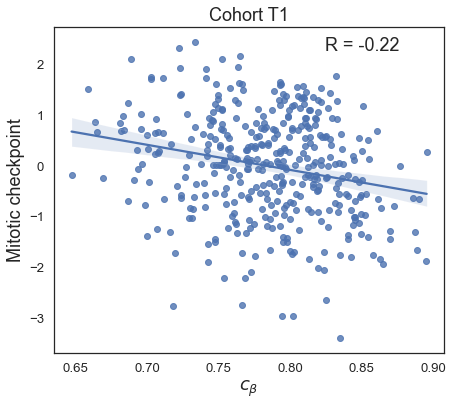

In [39]:
m_util.saveCorrelationPlot(clinical['TCGA'],
                           var_y='Mitotic Checkpoint',
                           restrict=True,
                           outfile=False,
                           outdir=figure_outdir,
                           x_size=7, y_size=6,
                           text_x=0.85, text_y=2.2, text_fontsize=18)

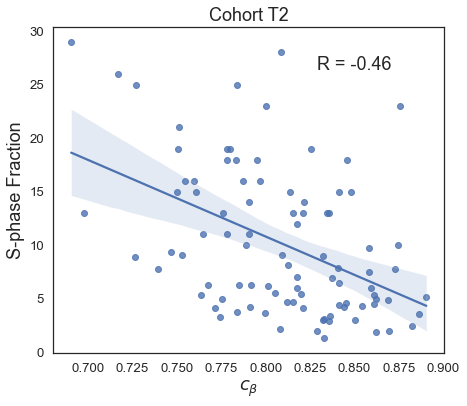

In [40]:
m_util.saveCorrelationPlot(clinical['ringner'], var_y='spfPercent', restrict=True, outfile=True,
                           outdir=figure_outdir,
                           label='S-phase Fraction',
                           x_size=7, y_size=6,
                           text_x=0.85, text_y=26, text_fontsize=18)

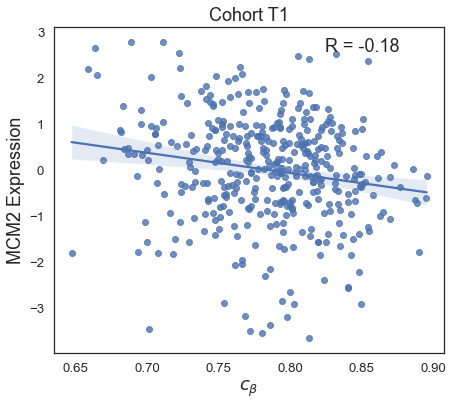

In [41]:
clinical['TCGA']['MCM2'] = markers_transformed_df.loc[gene_name.index[gene_name=='MCM2']].T
m_util.saveCorrelationPlot(clinical['TCGA'], var_y='MCM2', restrict=True, outfile=False,
                           outdir=figure_outdir,
                           x_size=7, y_size=6,
                           label='MCM2 Expression',
                           text_x=0.85, text_y=2.5, text_fontsize=18
                          )

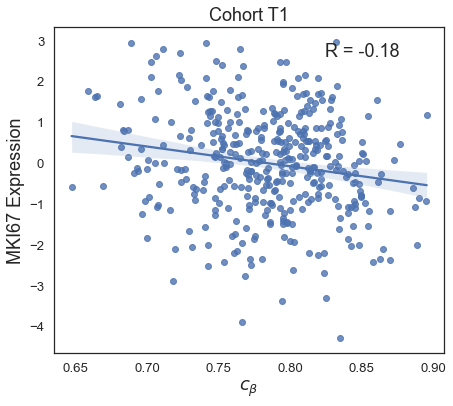

In [42]:
clinical['TCGA']['MKI67'] = markers_transformed_df.loc[gene_name.index[gene_name=='MKI67']].T
m_util.saveCorrelationPlot(clinical['TCGA'], var_y='MKI67', restrict=True, outfile=False,
                           outdir=figure_outdir,
                           x_size=7, y_size=6,
                           label='MKI67 Expression',
                           text_x=0.85, text_y=2.5, text_fontsize=18
                          )